In [63]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import pandas as pd
import sweetviz as sv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")





In [3]:
file_path = "metadata.csv"
data = pd.read_csv(file_path)
data.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

In [7]:
data_report = sv.analyze(data)
data_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
# Sex distribution (nan if unknown)
#ax = data["sex"].value_counts(dropna=False).plot.pie(y="sex", legend = True, autopct='%2.0f%%', figsize = (5,5), title = 'Sex Distribution')


## Divided into multiple models to give best result as possible
* part 1
* part 2
* part 3

In [9]:
## The first one to test the model
## "location"
## "date"
#df1 = data[["sex", "age", "went_icu", "temperature", "RT_PCR_positive"]]

## The Second one to bes test the model
#df2 = data[["clinical_notes", "RT_PCR_positive"]]


In [10]:
print("For ANN, CNN")
print("*"*70)

For ANN, CNN
**********************************************************************


In [59]:
class dataProcessing:
    
    def imageProcessing(self, train_location, test_location):
                
        train_datagen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
        test_datagen = ImageDataGenerator(rescale = 1./255)
        
        training_set = train_datagen.flow_from_directory(train_location,
                                                        target_size = (64, 64),
                                                        batch_size = 32,
                                                        class_mode = "binary")
        test_set = test_datagen.flow_from_directory(test_location,
                                           target_size = (64, 64),
                                           batch_size = 32,
                                           class_mode = "binary")
        return training_set, test_set  
    
    def dataCleanerForAnn(self, data): # this is only for our case
        df1 = data[["sex", "age", "went_icu", "temperature", "RT_PCR_positive"]]
        df1["sex"] = pd.get_dummies(df1["sex"], drop_first=True)
        df1["went_icu"] = pd.get_dummies(df1["went_icu"], drop_first=True)
        df1["RT_PCR_positive"] = pd.get_dummies(df1["RT_PCR_positive"], drop_first=True)

        df1["temperature"].fillna(df1["temperature"].mean(), inplace=True)
        df1["age"].fillna(df1["age"].mean(), inplace=True)
        return df1
    
    def splittingAndScaling(self, datapath):
        data = pd.read_csv(datapath)
        arrangedData  = self.dataCleanerForAnn(data)
        X = arrangedData.iloc[:, :-1].values
        y = arrangedData.iloc[: ,-1].values 
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        return X_train, X_test, y_train, y_test

In [41]:
class buildModel:
    
    def annModel(self, X_train, y_train):
        ann = tf.keras.models.Sequential()
        ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        ann.fit(X_train, y_train, batch_size = 32, epochs = 10)
        return ann
        
    def cnnModel(self, train, test):
        cnn = tf.keras.models.Sequential()
        cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
        cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
        cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        cnn.add(tf.keras.layers.Flatten())
        cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
        cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        cnn.fit(x = train, validation_data = test, epochs = 2)
        
        return cnn
    

In [2]:
#def classificationReportTest(y_test, y_pred):
#    print("result: ".upper())
#    print(confusion_matrix(y_test, y_pred))
#    print(classification_report(y_test, y_pred))
    
    

In [34]:
def predicter(im):
    # call the saved model as a pickle   
    # ????
    train_location = "DATA/train"
    test_location = "DATA/test"
    DP = dataProcessing()
    bM = buildModel()
    train, test  = DP.imageProcessing(train_location, test_location)
    cnn = bM.cnnModel(train, test)
    
    
    test_image = image.load_img(im, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image) # cnn == the saved model
    
    if result[0][0] <= 0.1: # test for the probabilites is less than 10%
        prediction = 'NON-COVID'
    else:
        prediction = 'COVID-19'

    #print(prediction)
    return prediction
    
    

In [35]:
def testSingleImagePrediction(): # here the point is to test random picked images(one from each)
    # from line 3 to line 9 we see as saved model
    
    
    ## Here I want to test when the model is saved
    # both these images are in the test-set(i.e one random from covid and one from noncovid)
    
    test_covid = "DATA/test/covid/"
    test_non_covid = "DATA/test/non/"

    Covid_in_test = [i for i in os.listdir(test_covid)]
    nonCovid_in_test = [i for i in os.listdir(test_non_covid)]
    
    test1 = test_covid + random.choice(Covid_in_test)
    test2 = test_non_covid + random.choice(nonCovid_in_test)
    
    imageCovid = mpimg.imread(test1)
    plt.imshow(imageCovid)
    plt.title("True image-1 of Covid")
    plt.show()
    
    imageNonCovid = mpimg.imread(test2)
    plt.imshow(imageNonCovid)
    plt.title("True image:2 of Non-Covid")
    plt.show()
    
    return ("Result of image-1 is: %s. Result of image-2 is: %s." %(predicter(test1), predicter(test2)) )
    

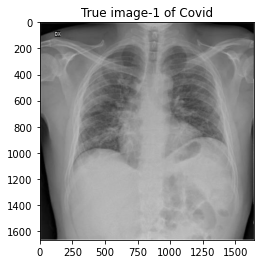

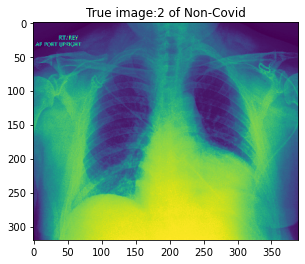

Found 2091 images belonging to 2 classes.
Found 3101 images belonging to 2 classes.
Epoch 1/2
66/66 [==============================] - 35s 516ms/step - loss: 0.2140 - accuracy: 0.9528 - val_loss: 0.0714 - val_accuracy: 0.9674
Epoch 2/2
66/66 [==============================] - 32s 485ms/step - loss: 0.1085 - accuracy: 0.9552 - val_loss: 0.0997 - val_accuracy: 0.9690
Found 2091 images belonging to 2 classes.
Found 3101 images belonging to 2 classes.
Epoch 1/2
66/66 [==============================] - 32s 477ms/step - loss: 0.2117 - accuracy: 0.8991 - val_loss: 0.1267 - val_accuracy: 0.9674
Epoch 2/2
66/66 [==============================] - 33s 497ms/step - loss: 0.1257 - accuracy: 0.9586 - val_loss: 0.0635 - val_accuracy: 0.9674


'Result of image-1 is: COVID-19. Result of image-2 is: COVID-19.'

In [36]:
testSingleImagePrediction()

In [61]:
def saveModel():
    # datapath
    train_location = "DATA/train"
    test_location = "DATA/test"
    metaData = "./metadata.csv"
    
    #classes
    DP = dataProcessing()
    models = buildModel()
    
    train, test  = DP.imageProcessing(train_location, test_location)
    X_train, X_test, y_train, y_test = DP.splittingAndScaling(metaData)
    
    print("CNN starts: \n")
    cnnModel = models.cnnModel(train, test)
    print("ANN starts: \n")
    annModel = models.annModel(X_train, y_train)
    
    #cnnModel.save("CNN.h5")
    #annModel.save("ANN.h5")

In [64]:
saveModel()

Found 2091 images belonging to 2 classes.
Found 3101 images belonging to 2 classes.
CNN starts: 

Epoch 1/2
66/66 [==============================] - 43s 641ms/step - loss: 0.2297 - accuracy: 0.9504 - val_loss: 0.1065 - val_accuracy: 0.9674
Epoch 2/2
66/66 [==============================] - 33s 499ms/step - loss: 0.1408 - accuracy: 0.9562 - val_loss: 0.0872 - val_accuracy: 0.9678
ANN starts: 

Epoch 1/10
21/21 [==============================] - 1s 1ms/step - loss: 0.7074 - accuracy: 0.4698
Epoch 2/10
21/21 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5295
Epoch 3/10
21/21 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5299
Epoch 4/10
21/21 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5342
Epoch 5/10
21/21 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5827
Epoch 6/10
21/21 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.5933
Epoch 7/10
21/21

In [39]:
def NoneReturner():
    print("default")

In [65]:
if __name__ == "__main__":
    #prediction()
    #saveModel()
    NoneReturner()


default
